1. process the input Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
import os, math, cv2
import numpy as np

# -------------------------------------------------------
# Utility for 4-way rotation (0°, 90°, 180°, 270°)
# -------------------------------------------------------
def rot90n(img, n):
    n %= 4
    if n == 0: return img
    if n == 1: return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    if n == 2: return cv2.rotate(img, cv2.ROTATE_180)
    return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

# -------------------------------------------------------
# 1. Read .rgb or normal image
# -------------------------------------------------------
def read_rgb_raw_auto(path):
    """
    Reads a .rgb 24-bit raw RGB file.
    Returns a color BGR image.
    """
    size   = os.path.getsize(path)
    pixels = size // 3
    side   = int(round(pixels**0.5))

    if side * side != pixels:
        raise ValueError(f"{path}: not square RGB24")

    with open(path, "rb") as f:
        raw = np.frombuffer(f.read(), dtype=np.uint8)

    # Interleaved guess
    inter     = raw.reshape((side, side, 3))
    inter_bgr = cv2.cvtColor(inter, cv2.COLOR_RGB2BGR)

    # Planar guess
    planar     = raw.reshape((3, side, side)).transpose(1,2,0)
    planar_bgr = cv2.cvtColor(planar, cv2.COLOR_RGB2BGR)

    # Choose more colorful one
    def colorfulness(bgr):
        b,g,r = cv2.split(bgr.astype(np.float32))
        return float(np.mean(np.std(np.stack([b,g,r],axis=-1),axis=-1)))

    return planar_bgr if colorfulness(planar_bgr) > colorfulness(inter_bgr) else inter_bgr

def read_image_auto(path):
    if path.lower().endswith(".rgb"):
        return read_rgb_raw_auto(path)
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(path)
    return img

# -------------------------------------------------------
# 2. Segment pieces by connected components
# -------------------------------------------------------
def segment_pieces(bgr, thresh=12, min_area=300):
    """
    Extracts puzzle pieces on black background.
    Returns list[{crop, mask}].
    """
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    mask = (gray > thresh).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), 1)

    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask, 8)

    pieces = []
    for i in range(1, num):
        x,y,w,h,area = stats[i]
        if area < min_area: 
            continue

        crop  = bgr[y:y+h, x:x+w]
        cmask = (labels[y:y+h, x:x+w] == i).astype(np.uint8)

        pieces.append({"crop": crop, "mask": cmask})

    return pieces

# -------------------------------------------------------
# 3. Deskew each piece using minAreaRect
# -------------------------------------------------------
def deskew_piece(piece):
    crop, mask = piece["crop"], piece["mask"]
    ys,xs = np.where(mask > 0)

    rect = cv2.minAreaRect(np.vstack([xs,ys]).T.astype(np.float32))
    angle, (w,h) = rect[2], rect[1]

    # Ensure upright orientation
    if w < h:
        angle += 90.0

    M = cv2.getRotationMatrix2D(
        (crop.shape[1]//2, crop.shape[0]//2), 
        angle, 1.0
    )
    rcrop  = cv2.warpAffine(crop, M, (crop.shape[1], crop.shape[0]),
                            flags=cv2.INTER_LINEAR, borderValue=(0,0,0))
    rmask  = cv2.warpAffine(mask, M, (mask.shape[1], mask.shape[0]),
                            flags=cv2.INTER_NEAREST, borderValue=0)

    ys,xs = np.where(rmask > 0)
    y0,y1 = ys.min(), ys.max()+1
    x0,x1 = xs.min(), xs.max()+1

    return rcrop[y0:y1, x0:x1]

# -------------------------------------------------------
# 4. Edge signatures for each side
# -------------------------------------------------------
def edge_signature(bgr, side, strip=3, N=128):
    """
    LAB+gradient signature for one edge.
    """
    h,w,_ = bgr.shape

    if side == 0:        # top
        line = np.mean(bgr[strip:2*strip,:,:], axis=0)
    elif side == 2:      # bottom
        line = np.mean(bgr[h-2*strip:h-strip,:,:], axis=0)
    elif side == 1:      # right
        line = np.mean(bgr[:,w-2*strip:w-strip,:], axis=1)
    else:                # left
        line = np.mean(bgr[:,strip:2*strip,:], axis=1)

    lab = cv2.cvtColor(
        line.astype(np.uint8).reshape(-1,1,3),
        cv2.COLOR_BGR2LAB
    ).reshape(-1,3).astype(np.float32)

    src = np.linspace(0, len(lab)-1, len(lab), dtype=np.float32)
    dst = np.linspace(0, len(lab)-1, N, dtype=np.float32)

    res  = np.vstack([np.interp(dst, src, lab[:,c]) for c in range(3)]).T  # N×3
    grad = np.gradient(res, axis=0)                                        # N×3

    return np.hstack([res, grad])                                          # N×6

# -------------------------------------------------------
# 5. Build all rotations and signatures
# -------------------------------------------------------
def build_rotations_and_sigs(uprights, Nsig=128):
    """
    Output:
      rotations[i][r]  = rotated version of piece i
      sigs[(i,r,s)]    = signature of side s of piece i under rotation r
    """
    rotations = [[rot90n(u, r) for r in range(4)] for u in uprights]
    sigs = {}

    for i in range(len(rotations)):
        for r in range(4):
            img = rotations[i][r]
            for s in range(4):
                sigs[(i,r,s)] = edge_signature(img, s, strip=3, N=Nsig)

    return rotations, sigs

# -------------------------------------------------------
# Public function: process input → pieces with rotations + sigs
# -------------------------------------------------------
def load_puzzle_pieces(path):
    """
    Main preprocessing function.
    Returns:
        uprights: list of deskewed upright piece images
        rotations: rotations[i][r] = piece i rotated r*90
        sigs: signatures for all rotated sides
    """
    print("Reading input...")
    img = read_image_auto(path)
    print("Segmenting pieces...")
    comps = segment_pieces(img)
    print(f"Found {len(comps)} pieces.")
    print("Deskewing pieces...")
    uprights = [deskew_piece(p) for p in comps]
    print("Building rotations + signatures...")
    rotations, sigs = build_rotations_and_sigs(uprights, Nsig=128)
    print("Done preprocessing.")
    return uprights, rotations, sigs


In [3]:
def show_upright_pieces(uprights, max_cols=4, title="Upright pieces"):
    N = len(uprights)
    cols = min(max_cols, N)
    rows = int(np.ceil(N / cols))

    plt.figure(figsize=(3*cols, 3*rows))
    for i, piece in enumerate(uprights):
        plt.subplot(rows, cols, i+1)
        plt.imshow(cv2.cvtColor(piece, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"{i}", fontsize=8)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [4]:
uprights, rotations, sigs = load_puzzle_pieces("./data/more_samples/sample1/sample1_rotate.rgb")

print("Number of pieces:", len(uprights))
print("Piece 0 original shape:", uprights[0].shape)
print("Piece 0 rotation 2 shape:", rotations[0][2].shape)
print("Signature for piece 0, rot 1, top side:", sigs[(0,1,0)].shape)

Reading input...
Segmenting pieces...
Found 20 pieces.
Deskewing pieces...
Building rotations + signatures...
Done preprocessing.
Number of pieces: 20
Piece 0 original shape: (81, 84, 3)
Piece 0 rotation 2 shape: (81, 84, 3)
Signature for piece 0, rot 1, top side: (128, 6)


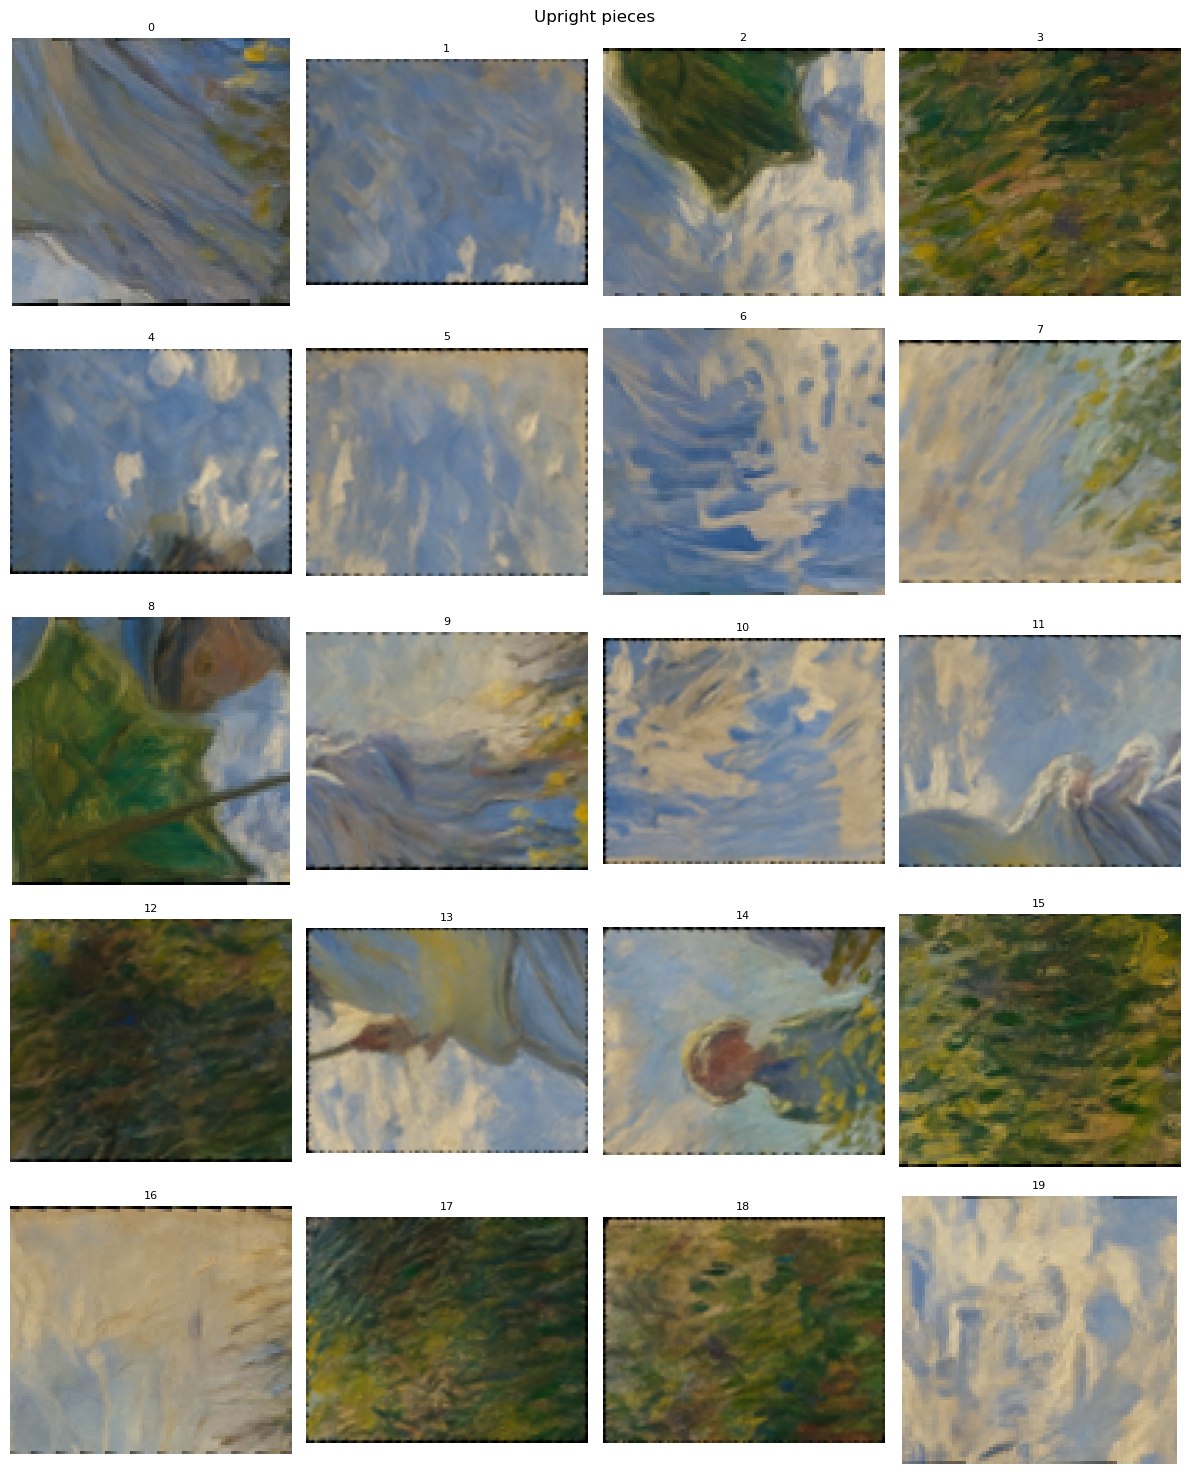

In [5]:
show_upright_pieces(uprights)

fix black alialsing ==> final version of preprocess

In [6]:
import os, cv2, math
import numpy as np

# -------------------------------------------------------
# Basic rotation helper
# -------------------------------------------------------
def rot90n(img, n):
    n %= 4
    if n == 0: return img
    if n == 1: return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    if n == 2: return cv2.rotate(img, cv2.ROTATE_180)
    return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

# -------------------------------------------------------
# Reading .rgb or normal image
# -------------------------------------------------------
def read_rgb_raw_auto(path):
    size   = os.path.getsize(path)
    pixels = size // 3
    side   = int(round(pixels**0.5))
    if side * side != pixels:
        raise ValueError(f"{path}: not square RGB24 (pixels={pixels})")

    with open(path, "rb") as f:
        raw = np.frombuffer(f.read(), dtype=np.uint8)

    # interleaved guess
    inter     = raw.reshape((side, side, 3))
    inter_bgr = cv2.cvtColor(inter, cv2.COLOR_RGB2BGR)

    # planar guess
    planar     = raw.reshape((3, side, side)).transpose(1, 2, 0)
    planar_bgr = cv2.cvtColor(planar, cv2.COLOR_RGB2BGR)

    def colorfulness(bgr):
        b,g,r = cv2.split(bgr.astype(np.float32))
        return float(np.mean(np.std(np.stack([b,g,r], axis=-1), axis=-1)))

    return planar_bgr if colorfulness(planar_bgr) > colorfulness(inter_bgr) else inter_bgr

def read_image_auto(path):
    if path.lower().endswith(".rgb"):
        return read_rgb_raw_auto(path)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(path)
    return img

# -------------------------------------------------------
# 1) Segment pieces (with masks)
# -------------------------------------------------------
def segment_pieces(bgr, thresh=None, min_area=300):
    """
    Segment puzzle pieces on a dark background.

    If `thresh` is None, choose it adaptively based on the darkest 5% of pixels.
    This makes it work for darker paintings like Mona Lisa as well.
    """
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    if thresh is None:
        # Use darkest 5% of pixels as "background" and set threshold a bit above that
        flat = gray.reshape(-1)
        p5   = np.percentile(flat, 5)              # typical dark background level
        thr  = p5 + 3                              # a small margin above it
        thr  = max(1, min(50, thr))                # clamp to a sane range
    else:
        thr = thresh

    # Foreground = pixels clearly brighter than background
    mask = (gray > thr).astype(np.uint8)

    # Light morphology to clean noise
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    # Connected components
    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask, 8)

    pieces = []
    for i in range(1, num):
        x,y,w,h,area = stats[i]
        if area < min_area:
            continue
        crop  = bgr[y:y+h, x:x+w]
        cmask = (labels[y:y+h, x:x+w] == i).astype(np.uint8)
        pieces.append({"crop": crop, "mask": cmask})

    return pieces


# -------------------------------------------------------
# 2) Deskew piece (keep rotated mask)
# -------------------------------------------------------
def deskew_piece_masked(piece):
    """
    Rotate piece so its edges are axis-aligned.
    Returns (rotated_crop, rotated_mask), both tightly cropped.
    """
    crop, mask = piece["crop"], piece["mask"]
    ys, xs = np.where(mask > 0)

    rect = cv2.minAreaRect(np.vstack([xs, ys]).T.astype(np.float32))
    angle, (w, h) = rect[2], rect[1]
    if w < h:
        angle += 90.0

    center = (crop.shape[1] // 2, crop.shape[0] // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    rcrop = cv2.warpAffine(
        crop, M, (crop.shape[1], crop.shape[0]),
        flags=cv2.INTER_LINEAR, borderValue=(0,0,0)
    )
    rmask = cv2.warpAffine(
        mask, M, (mask.shape[1], mask.shape[0]),
        flags=cv2.INTER_NEAREST, borderValue=0
    )

    ys, xs = np.where(rmask > 0)
    y0, y1 = ys.min(), ys.max() + 1
    x0, x1 = xs.min(), xs.max() + 1

    rcrop = rcrop[y0:y1, x0:x1]
    rmask = rmask[y0:y1, x0:x1]

    return rcrop, rmask

# -------------------------------------------------------
# 3) Mask-aware edge signature (aliasing-safe)
# -------------------------------------------------------
def edge_signature_masked(bgr, mask, side, strip=3, N=128):
    """
    Compute a LAB+gradient signature for one edge, but ignore pixels where mask == 0.
    This avoids using black aliasing artifacts created by rotation.
    """
    h, w, _ = bgr.shape

    if side == 0:      # top edge
        band  = bgr[0:3*strip, :, :]
        mband = mask[0:3*strip, :]
        cols = []
        for x in range(w):
            ys = np.where(mband[:, x] > 0)[0]
            if len(ys) == 0:
                # fallback: use middle of band
                pix = band[strip:2*strip, x, :].mean(axis=0)
            else:
                pix = band[ys, x, :].mean(axis=0)
            cols.append(pix)
        line = np.vstack(cols)   # w × 3

    elif side == 2:    # bottom edge
        band  = bgr[h-3*strip:h, :, :]
        mband = mask[h-3*strip:h, :]
        cols = []
        for x in range(w):
            ys = np.where(mband[:, x] > 0)[0]
            if len(ys) == 0:
                pix = band[strip:2*strip, x, :].mean(axis=0)
            else:
                pix = band[ys, x, :].mean(axis=0)
            cols.append(pix)
        line = np.vstack(cols)

    elif side == 1:    # right edge
        band  = bgr[:, w-3*strip:w, :]
        mband = mask[:, w-3*strip:w]
        rows = []
        for y in range(h):
            xs = np.where(mband[y, :] > 0)[0]
            if len(xs) == 0:
                pix = band[y, strip:2*strip, :].mean(axis=0)
            else:
                pix = band[y, xs, :].mean(axis=0)
            rows.append(pix)
        line = np.vstack(rows)   # h × 3

    else:              # left edge
        band  = bgr[:, 0:3*strip, :]
        mband = mask[:, 0:3*strip]
        rows = []
        for y in range(h):
            xs = np.where(mband[y, :] > 0)[0]
            if len(xs) == 0:
                pix = band[y, strip:2*strip, :].mean(axis=0)
            else:
                pix = band[y, xs, :].mean(axis=0)
            rows.append(pix)
        line = np.vstack(rows)

    # convert sampled RGB line to LAB and add gradient
    lab = cv2.cvtColor(
        line.astype(np.uint8).reshape(-1,1,3),
        cv2.COLOR_BGR2LAB
    ).reshape(-1,3).astype(np.float32)

    src = np.linspace(0, len(lab)-1, len(lab), dtype=np.float32)
    dst = np.linspace(0, len(lab)-1, N,       dtype=np.float32)

    res  = np.vstack([np.interp(dst, src, lab[:,c]) for c in range(3)]).T  # N×3
    grad = np.gradient(res, axis=0)                                       # N×3

    return np.hstack([res, grad])                                         # N×6

# -------------------------------------------------------
# 4) Build rotations + mask-aware signatures
# -------------------------------------------------------
def build_rotations_and_sigs_masked(uprights, masks, Nsig=128):
    """
    Inputs:
        uprights[i] : deskewed piece image i (BGR)
        masks[i]    : its mask (0/1)
    Outputs:
        rotations[i][r]      : piece i rotated by r*90°
        rotations_masks[i][r]: mask rotated similarly
        sigs[(i,r,s)]        : signature for side s of that rotation
    """
    rotations = []
    rotations_masks = []

    for img, m in zip(uprights, masks):
        rs = [rot90n(img, r) for r in range(4)]
        ms = [rot90n(m,   r) for r in range(4)]
        rotations.append(rs)
        rotations_masks.append(ms)

    sigs = {}
    for i in range(len(rotations)):
        for r in range(4):
            img = rotations[i][r]
            msk = rotations_masks[i][r]
            for s in range(4):
                sigs[(i,r,s)] = edge_signature_masked(img, msk, s, strip=3, N=Nsig)

    return rotations, rotations_masks, sigs

# -------------------------------------------------------
# 5) Public loader: aliasing-safe preprocessing
# -------------------------------------------------------
def load_puzzle_pieces_masked(path):
    """
    Full preprocessing with aliasing-safe edges.
    Returns:
        uprights        : list of deskewed piece images
        upright_masks   : list of masks
        rotations       : rotations[i][r]
        rotations_masks : rotations_masks[i][r]
        sigs            : signatures[(i,r,s)]
    """
    print("Reading input...")
    img = read_image_auto(path)

    print("Segmenting pieces...")
    comps = segment_pieces(img)
    print(f"Found {len(comps)} pieces.")

    print("Deskewing pieces (with masks)...")
    uprights, upright_masks = [], []
    for p in comps:
        rcrop, rmask = deskew_piece_masked(p)
        uprights.append(rcrop)
        upright_masks.append(rmask)

    print("Building rotations + mask-aware signatures...")
    rotations, rotations_masks, sigs = build_rotations_and_sigs_masked(
        uprights, upright_masks, Nsig=128
    )

    print("Done preprocessing (aliasing-safe).")
    return uprights, upright_masks, rotations, rotations_masks, sigs

# Optional: backwards-compatible wrapper if you still call load_puzzle_pieces(...)
def load_puzzle_pieces(path):
    """
    Compatibility wrapper: keeps your old call
        uprights, rotations, sigs = load_puzzle_pieces(path)
    but internally uses the aliasing-safe pipeline.
    """
    uprights, masks, rotations, rotations_masks, sigs = load_puzzle_pieces_masked(path)
    return uprights, rotations, sigs


In [7]:
uprights, masks, rotations, rotations_masks, sigs = load_puzzle_pieces_masked("./data/mona_lisa_translate.rgb")

Reading input...
Segmenting pieces...
Found 16 pieces.
Deskewing pieces (with masks)...
Building rotations + mask-aware signatures...
Done preprocessing (aliasing-safe).


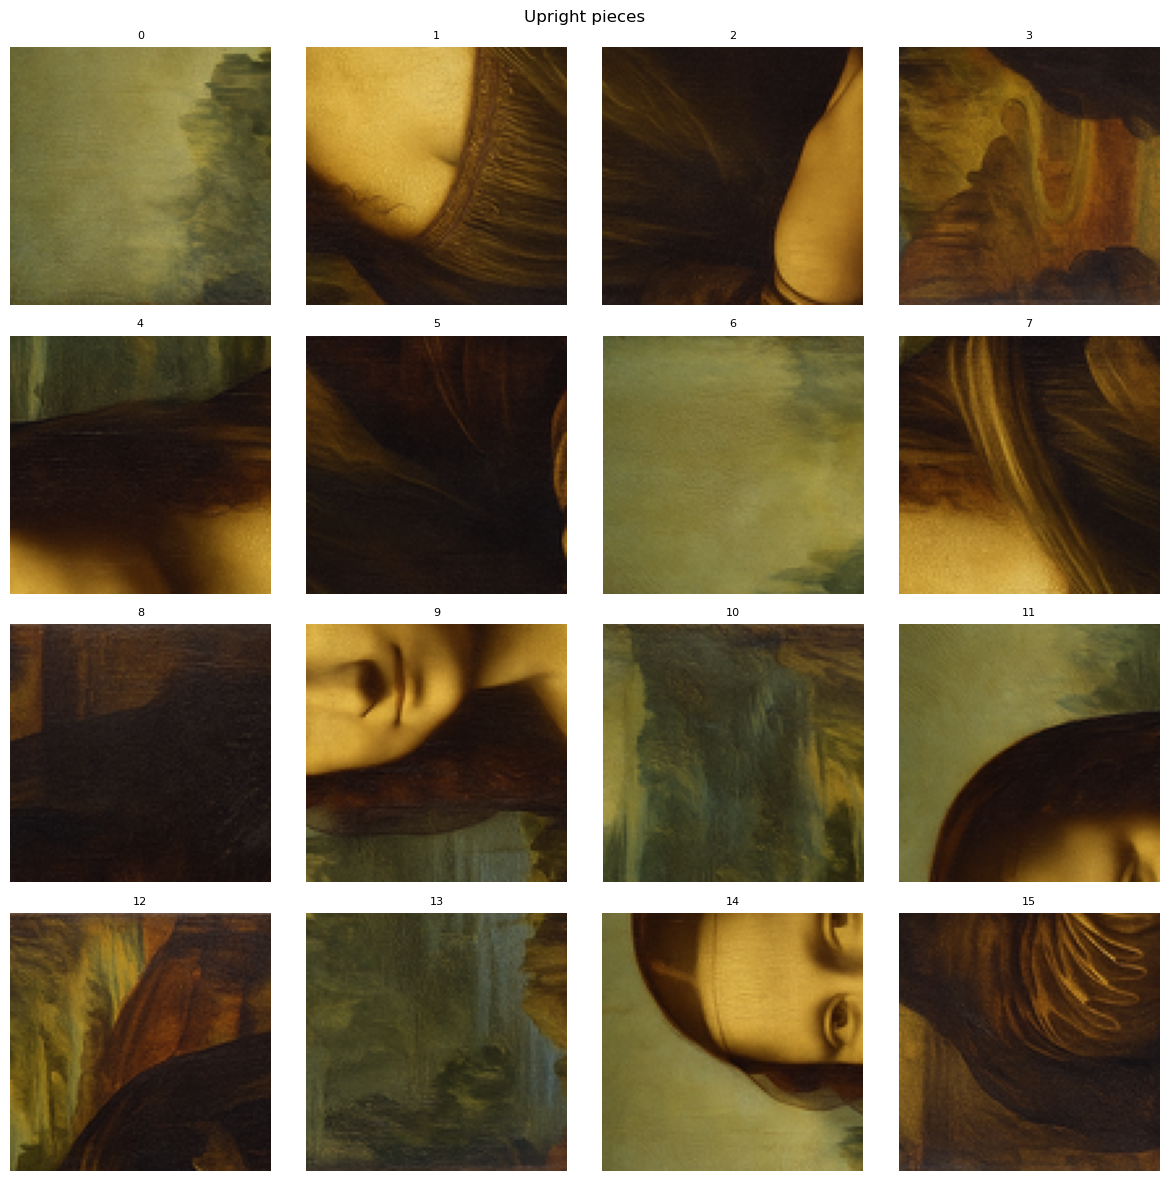

In [8]:
show_upright_pieces(uprights)


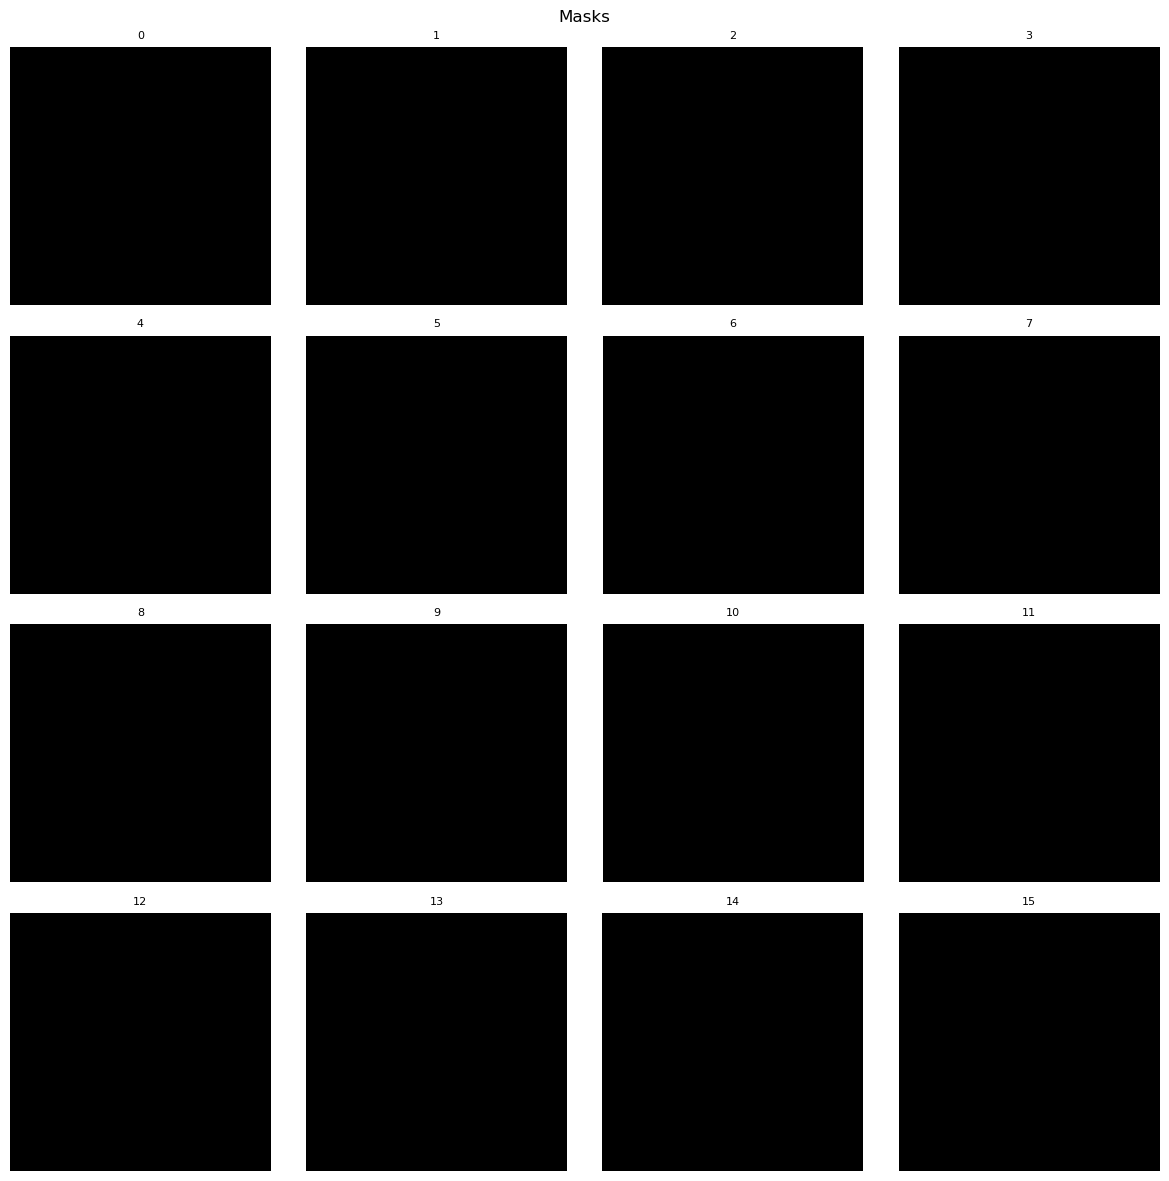

In [9]:
def show_masks(masks, max_cols=4, title="Masks"):
    N = len(masks)
    cols = min(max_cols, N)
    rows = int(np.ceil(N / cols))

    plt.figure(figsize=(3*cols, 3*rows))
    for i, m in enumerate(masks):
        plt.subplot(rows, cols, i+1)
        plt.imshow(m, cmap="gray")
        plt.axis("off")
        plt.title(f"{i}", fontsize=8)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_masks(masks)

In [10]:
import numpy as np
import cv2, os, math
from collections import defaultdict

# -------------------------------------------------------
# Helpers shared by assembly
# -------------------------------------------------------
OPP = {0:2, 1:3, 2:0, 3:1}   # opposite sides: T-B, R-L

def infer_grid_dims(N):
    """
    Given N pieces, return grid dims (R,C) where R*C == N
    and |R-C| is minimal (most square-ish).
    e.g. N=20 -> (4,5)
    """
    best = None
    for r in range(1, int(math.sqrt(N)) + 1):
        if N % r == 0:
            c = N // r
            if best is None or abs(r-c) < abs(best[0]-best[1]):
                best = (r, c)
    return best

def edge_distance(sigA, sigB):
    # distance between edge signatures (reverse one side)
    return float(np.linalg.norm(sigA - sigB[::-1]))

# -------------------------------------------------------
# Border detection (rotation-invariant)
# -------------------------------------------------------
def compute_outerness(rotations, sigs):
    """
    For each (piece i, rotation r, side s) compute its best match distance to
    any *opposite* side of any other piece. Large distance => likely border.
    """
    keys = list(sigs.keys())  # (i,r,s)
    outer = {}
    vals = []

    for (i,ri,si) in keys:
        A = sigs[(i,ri,si)]
        best = np.inf
        for (j,rj,sj) in keys:
            if i == j:
                continue
            if sj != OPP[si]:
                continue
            d = float(np.linalg.norm(A - sigs[(j,rj,sj)][::-1]))
            if d < best:
                best = d
        outer[(i,ri,si)] = best
        vals.append(best)

    vals = np.array(vals, dtype=np.float32)
    med = np.median(vals)
    mad = np.median(np.abs(vals - med)) + 1e-8
    thr = med + 2.5 * mad     # edges with distance > thr are "outer"

    border_mask = {k: (outer[k] > thr) for k in outer}
    return outer, border_mask, thr

def classify_pieces(rotations, border_mask):
    """
    Rotation-invariant piece roles and border sides.

    roles[i] in {"corner","edge","interior"}
    border_sides[(i,r)] = set of sides that are border in rotation r
    """
    N = len(rotations)
    border_sides = {}
    roles = {}

    for i in range(N):
        # canonical sides c=0..3 with votes over rotations
        votes = {c:0 for c in range(4)}
        for r in range(4):
            for s in range(4):
                if border_mask[(i,r,s)]:
                    c = (s - r) % 4
                    votes[c] += 1
        canonical_is_border = {c:(votes[c] > 0) for c in range(4)}

        # map back to each rotation
        for r in range(4):
            sides_r = set()
            for s in range(4):
                c = (s - r) % 4
                if canonical_is_border[c]:
                    sides_r.add(s)
            border_sides[(i,r)] = sides_r

        n_border = sum(1 for c in range(4) if canonical_is_border[c])
        if n_border >= 2:
            roles[i] = "corner"
        elif n_border == 1:
            roles[i] = "edge"
        else:
            roles[i] = "interior"
    return roles, border_sides

def outward_sides_for_cell(r, c, R, C):
    sides = set()
    if r == 0:   sides.add(0)   # top
    if c == C-1: sides.add(1)   # right
    if r == R-1: sides.add(2)   # bottom
    if c == 0:   sides.add(3)   # left
    return sides

def rotation_ok_for_cell(i, rot, r, c, R, C, border_sides):
    outward = outward_sides_for_cell(r, c, R, C)
    sides   = border_sides[(i, rot)]
    # all outward sides must be border edges
    for s in outward:
        if s not in sides:
            return False
    return True

def inward_border_penalty(i, rot, r, c, R, C, border_sides, gamma=30.0):
    outward = outward_sides_for_cell(r, c, R, C)
    sides   = border_sides[(i, rot)]
    inward  = {0,1,2,3} - outward
    n_bad   = sum(1 for s in inward if s in sides)
    return gamma * n_bad

# -------------------------------------------------------
# Best oriented match for each pair + MST over pieces
# -------------------------------------------------------
def best_pair_between(i, j, sigs):
    """
    For piece pair (i,j), find best orientation:
      ri, si, rj, sj where sj = OPP[si]
    Returns (d, ri, si, rj, sj)
    """
    best = (1e18, 0,0,0,0)
    for ri in range(4):
        for si in range(4):
            sj = OPP[si]
            A = sigs[(i,ri,si)]
            for rj in range(4):
                d = edge_distance(A, sigs[(j,rj,sj)])
                if d < best[0]:
                    best = (d, ri, si, rj, sj)
    return best

def kruskal_mst(N, edges):
    parent = list(range(N))
    rank   = [0]*N

    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union(a,b):
        ra,rb = find(a), find(b)
        if ra == rb:
            return False
        if rank[ra] < rank[rb]:
            parent[ra] = rb
        elif rank[ra] > rank[rb]:
            parent[rb] = ra
        else:
            parent[rb] = ra
            rank[ra]  += 1
        return True

    mst = []
    for w,i,j in sorted(edges, key=lambda e:e[0]):
        if union(i,j):
            mst.append((w,i,j))
            if len(mst) == N-1:
                break
    return mst

# -------------------------------------------------------
# Seam cost + canvas rendering
# -------------------------------------------------------
def seam_cost_between_cells(grid, rotations, sigs, r1, c1, r2, c2):
    (i1, rot1) = grid[r1][c1]
    (i2, rot2) = grid[r2][c2]

    # same row: horizontal neighbors
    if r1 == r2:
        if c2 == c1 + 1:
            s1, s2 = 1, 3   # right of left piece vs left of right piece
        else:
            s1, s2 = 3, 1
    # same column: vertical neighbors
    elif c1 == c2:
        if r2 == r1 + 1:
            s1, s2 = 2, 0   # bottom vs top
        else:
            s1, s2 = 0, 2
    else:
        return 0.0

    sig1 = sigs[(i1, rot1, s1)]
    sig2 = sigs[(i2, rot2, s2)]
    return float(np.linalg.norm(sig1 - sig2[::-1]))

def total_grid_seam_cost(grid, rotations, sigs):
    R, C = len(grid), len(grid[0])
    total = 0.0
    for r in range(R):
        for c in range(C-1):
            total += seam_cost_between_cells(grid, rotations, sigs, r, c, r, c+1)
    for r in range(R-1):
        for c in range(C):
            total += seam_cost_between_cells(grid, rotations, sigs, r, c, r+1, c)
    return total

def render_grid_true_sizes(grid, rotations, out_path=None, show=True, title=""):
    import matplotlib.pyplot as plt

    R, C = len(grid), len(grid[0])

    row_heights = [0]*R
    col_widths  = [0]*C
    # determine row heights / col widths from max piece sizes
    for r in range(R):
        for c in range(C):
            i, rot_idx = grid[r][c]
            img = rotations[i][rot_idx]
            h, w = img.shape[:2]
            row_heights[r] = max(row_heights[r], h)
            col_widths[c]  = max(col_widths[c],  w)

    row_off = [0]*R
    col_off = [0]*C
    for r in range(1,R):
        row_off[r] = row_off[r-1] + row_heights[r-1]
    for c in range(1,C):
        col_off[c] = col_off[c-1] + col_widths[c-1]

    H = sum(row_heights)
    W = sum(col_widths)
    canvas = np.zeros((H,W,3), np.uint8)

    for r in range(R):
        for c in range(C):
            i, rot_idx = grid[r][c]
            img = rotations[i][rot_idx]
            h, w = img.shape[:2]
            y, x = row_off[r], col_off[c]
            canvas[y:y+h, x:x+w] = img

    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        cv2.imwrite(out_path, canvas)

    if show:
        plt.figure(figsize=(6,6))
        plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(title)
        plt.show()

    return canvas

# -------------------------------------------------------
# Rectangular MST assembly with orientation-aware bonus
# -------------------------------------------------------
def assemble_rectangular_multi_seed(rotations, sigs, roles, border_sides,
                                    best_pairs, mst_adj,
                                    lam_mst=80.0, gamma=30.0,
                                    lam_size_h=40.0, lam_size_w=40.0):
    """
    N pieces -> rectangular grid R×C (R*C=N, as square-ish as possible).
    Uses:
      - border constraints
      - MST adjacency + orientation bonus
      - size-consistency penalty so rows share height and columns share width.
    """
    N = len(rotations)
    R, C = infer_grid_dims(N)
    print(f"Using grid {R} x {C} for N={N}")

    # ---------- cost function (captures row/col targets by closure) ----------
    def make_local_cell_cost(row_target_h, col_target_w):
        def local_cell_cost(grid, i, rot, rr, cc):
            cost  = 0.0
            bonus = 0.0

            # seam with top neighbor
            if rr > 0 and grid[rr-1][cc] is not None:
                j, rj = grid[rr-1][cc]
                sig1 = sigs[(j, rj, 2)]   # bottom of top
                sig2 = sigs[(i, rot, 0)]  # top of current
                d    = float(np.linalg.norm(sig1 - sig2[::-1]))
                cost += d

                if j in mst_adj[i]:
                    bonus += 10.0

                bp = best_pairs.get((j,i), None)
                if bp is not None:
                    ri_best, si_best, rj_best, sj_best, d_best = bp
                    if (rj,2,rot,0) == (ri_best, si_best, rj_best, sj_best):
                        bonus += lam_mst

            # seam with left neighbor
            if cc > 0 and grid[rr][cc-1] is not None:
                j, rj = grid[rr][cc-1]
                sig1 = sigs[(j, rj, 1)]   # right
                sig2 = sigs[(i, rot, 3)]  # left
                d    = float(np.linalg.norm(sig1 - sig2[::-1]))
                cost += d

                if j in mst_adj[i]:
                    bonus += 10.0

                bp = best_pairs.get((j,i), None)
                if bp is not None:
                    ri_best, si_best, rj_best, sj_best, d_best = bp
                    if (rj,1,rot,3) == (ri_best, si_best, rj_best, sj_best):
                        bonus += lam_mst

            # border penalties (don't put border edges inside the image)
            cost += inward_border_penalty(i, rot, rr, cc, R, C, border_sides, gamma=gamma)

            # ---- NEW: size-consistency penalties ----
            h, w = rotations[i][rot].shape[:2]

            # match row height if row height already decided
            if row_target_h[rr] is not None:
                cost += lam_size_h * abs(h - row_target_h[rr])

            # match column width if column width already decided
            if col_target_w[cc] is not None:
                cost += lam_size_w * abs(w - col_target_w[cc])

            return cost - bonus
        return local_cell_cost

    # ---------- candidate seeds for (0,0) ----------
    seeds = []
    for i in range(N):
        for r in range(4):
            if rotation_ok_for_cell(i, r, 0, 0, R, C, border_sides):
                seeds.append((i,r))
    if not seeds:
        seeds = [(i,r) for i in range(N) for r in range(4)]

    print(f"Trying {len(seeds)} seeds for top-left")

    best_grid = None
    best_cost = float("inf")
    best_seed = None

    # ---------- try each seed ----------
    for seed in seeds:
        (i0, r0) = seed
        grid = [[None]*C for _ in range(R)]
        used = set([i0])
        grid[0][0] = (i0, r0)

        # row/column size targets, learned as we fill the grid
        row_target_h = [None]*R
        col_target_w = [None]*C
        h0, w0 = rotations[i0][r0].shape[:2]
        row_target_h[0] = h0
        col_target_w[0] = w0

        local_cell_cost = make_local_cell_cost(row_target_h, col_target_w)

        for rr in range(R):
            for cc in range(C):
                if rr == 0 and cc == 0:
                    continue

                best = (1e18, None)

                # 1st pass: respect border constraints
                for i in range(N):
                    if i in used:
                        continue
                    for rot in range(4):
                        if not rotation_ok_for_cell(i, rot, rr, cc, R, C, border_sides):
                            continue
                        v = local_cell_cost(grid, i, rot, rr, cc)
                        if v < best[0]:
                            best = (v, (i,rot))

                # if nothing found (rare), ignore border constraint
                if best[1] is None:
                    for i in range(N):
                        if i in used:
                            continue
                        for rot in range(4):
                            v = local_cell_cost(grid, i, rot, rr, cc)
                            if v < best[0]:
                                best = (v, (i,rot))

                i_best, rot_best = best[1]
                grid[rr][cc] = (i_best, rot_best)
                used.add(i_best)

                # update row/col size targets if not set yet
                h, w = rotations[i_best][rot_best].shape[:2]
                if row_target_h[rr] is None:
                    row_target_h[rr] = h
                if col_target_w[cc] is None:
                    col_target_w[cc] = w

        cost = total_grid_seam_cost(grid, rotations, sigs)
        if cost < best_cost:
            best_cost = cost
            best_grid = grid
            best_seed = seed

    print("Best seed:", best_seed, "with seam cost:", best_cost)
    return best_grid


# -------------------------------------------------------
# Full solver that plugs into your masked preprocessing
# -------------------------------------------------------
def solve_puzzle_mst_rectangular(path, out_dir="./outputs_mst_rect", show=True):
    """
    Full pipeline:
      - aliasing-safe preprocessing (masks)
      - border detection (rotation-invariant)
      - orientation-aware MST over pieces
      - rectangular grid assembly using multi-seed greedy with MST+border bonuses
      - renders true-size rectangular canvas
    """
    from math import sqrt
    print("=== Solving:", path, "===")

    # 1) aliasing-safe preprocessing (from previous step)
    uprights, masks, rotations, rotations_masks, sigs = load_puzzle_pieces_masked(path)
    N = len(rotations)
    print(f"{os.path.basename(path)}: {N} pieces")

    # 2) border roles
    outer, border_mask, thr = compute_outerness(rotations, sigs)
    roles, border_sides = classify_pieces(rotations, border_mask)
    print("Border threshold:", thr)

    # 3) best oriented pairs + MST
    edges      = []
    best_pairs = {}
    for i in range(N):
        for j in range(i+1, N):
            d,ri,si,rj,sj = best_pair_between(i, j, sigs)
            edges.append((d,i,j))
            best_pairs[(i,j)] = (ri,si,rj,sj,d)
            best_pairs[(j,i)] = (rj,sj,ri,si,d)

    mst = kruskal_mst(N, edges)
    mst_adj = defaultdict(set)
    for w,i,j in mst:
        mst_adj[i].add(j)
        mst_adj[j].add(i)

    # 4) assemble rectangular grid
    grid = assemble_rectangular_multi_seed(
        rotations, sigs, roles, border_sides,
        best_pairs, mst_adj,
        lam_mst=80.0, gamma=30.0
    )

    # 5) render
    base = os.path.splitext(os.path.basename(path))[0]
    out_path = os.path.join(out_dir, f"{base}_mst_rect.png")
    canvas = render_grid_true_sizes(
        grid, rotations,
        out_path=out_path, show=show,
        title=f"MST rect: {base}"
    )
    print("Saved ->", out_path)
    return canvas


=== Solving: ./data/starry_night_translate.rgb ===
Reading input...
Segmenting pieces...
Found 16 pieces.
Deskewing pieces (with masks)...
Building rotations + mask-aware signatures...
Done preprocessing (aliasing-safe).
starry_night_translate.rgb: 16 pieces
Border threshold: 478.91837
Using grid 4 x 4 for N=16
Trying 64 seeds for top-left
Best seed: (10, 2) with seam cost: 9201.00027166329


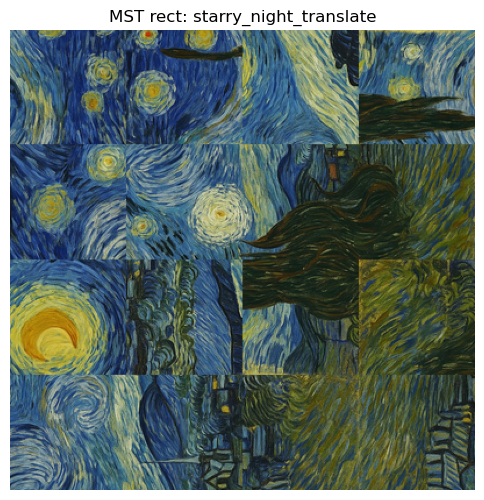

Saved -> ./outputs_mst_rect\starry_night_translate_mst_rect.png


array([[[108,  77,  43],
        [143, 139, 115],
        [146, 146, 124],
        ...,
        [114, 147, 128],
        [127, 141, 102],
        [128, 124,  81]],

       [[149, 125,  85],
        [131, 116,  83],
        [151, 146, 119],
        ...,
        [135, 115,  62],
        [148, 127,  67],
        [136, 110,  53]],

       [[166, 155, 120],
        [143, 123,  87],
        [140, 121,  88],
        ...,
        [138, 110,  56],
        [124, 109,  67],
        [104, 117,  92]],

       ...,

       [[123, 101,  74],
        [134, 121,  94],
        [129, 113,  86],
        ...,
        [ 75,  82,  53],
        [ 85,  93,  64],
        [ 90,  95,  64]],

       [[136, 115,  85],
        [124, 108,  78],
        [118, 101,  76],
        ...,
        [ 59,  65,  37],
        [ 81,  88,  61],
        [ 76,  75,  46]],

       [[139, 123,  91],
        [116, 103,  75],
        [125, 108,  78],
        ...,
        [ 77,  85,  53],
        [ 76,  88,  61],
        [ 78,  79,  52]]

In [38]:
solve_puzzle_mst_rectangular("./data/starry_night_translate.rgb")

=== Solving: ./data/starry_night_translate.rgb ===
Reading input...
Segmenting pieces...
Found 16 pieces.
Deskewing pieces (with masks)...
Building rotations + mask-aware signatures...
Done preprocessing (aliasing-safe).
starry_night_translate.rgb: 16 pieces
Border threshold: 478.91837
Using grid 4 x 4 for N=16
Trying 64 seeds for top-left
Best seed: (10, 2) with seam cost: 9201.00027166329


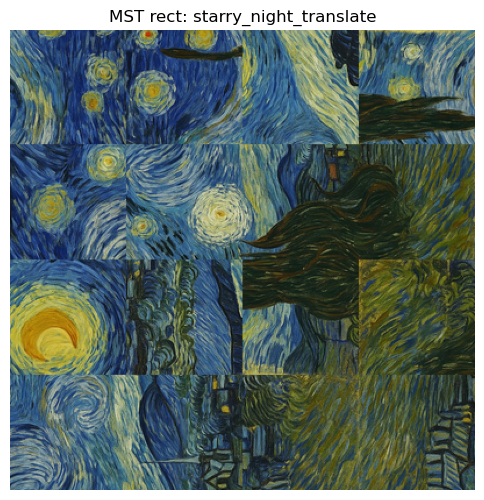

Saved -> ./outputs_mst_rect\starry_night_translate_mst_rect.png


array([[[108,  77,  43],
        [143, 139, 115],
        [146, 146, 124],
        ...,
        [114, 147, 128],
        [127, 141, 102],
        [128, 124,  81]],

       [[149, 125,  85],
        [131, 116,  83],
        [151, 146, 119],
        ...,
        [135, 115,  62],
        [148, 127,  67],
        [136, 110,  53]],

       [[166, 155, 120],
        [143, 123,  87],
        [140, 121,  88],
        ...,
        [138, 110,  56],
        [124, 109,  67],
        [104, 117,  92]],

       ...,

       [[123, 101,  74],
        [134, 121,  94],
        [129, 113,  86],
        ...,
        [ 75,  82,  53],
        [ 85,  93,  64],
        [ 90,  95,  64]],

       [[136, 115,  85],
        [124, 108,  78],
        [118, 101,  76],
        ...,
        [ 59,  65,  37],
        [ 81,  88,  61],
        [ 76,  75,  46]],

       [[139, 123,  91],
        [116, 103,  75],
        [125, 108,  78],
        ...,
        [ 77,  85,  53],
        [ 76,  88,  61],
        [ 78,  79,  52]]

In [11]:
solve_puzzle_mst_rectangular("./data/starry_night_translate.rgb")

=== Solving: ./data/mona_lisa_translate.rgb ===
Reading input...
Segmenting pieces...
Found 16 pieces.
Deskewing pieces (with masks)...
Building rotations + mask-aware signatures...
Done preprocessing (aliasing-safe).
mona_lisa_translate.rgb: 16 pieces
Border threshold: 397.26538
Using grid 4 x 4 for N=16
Trying 6 seeds for top-left
Best seed: (4, 2) with seam cost: 9955.832423254826


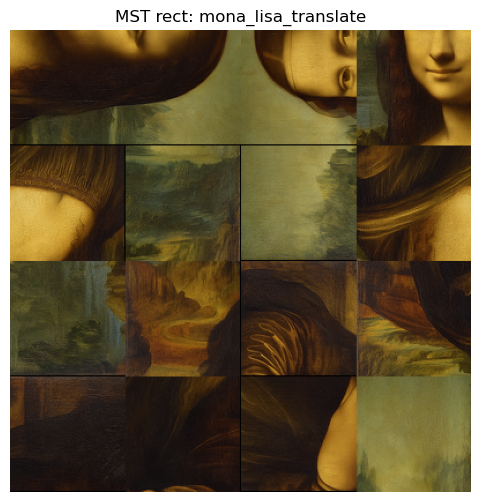

Saved -> ./outputs_mst_rect\mona_lisa_translate_mst_rect.png


array([[[ 51, 147, 189],
        [ 45, 141, 183],
        [ 43, 137, 181],
        ...,
        [ 64, 170, 214],
        [ 55, 162, 206],
        [ 61, 169, 213]],

       [[ 45, 140, 181],
        [ 48, 143, 184],
        [ 39, 132, 175],
        ...,
        [ 62, 170, 214],
        [ 60, 169, 213],
        [ 65, 175, 218]],

       [[ 47, 146, 187],
        [ 48, 144, 186],
        [ 48, 144, 185],
        ...,
        [ 71, 178, 221],
        [ 67, 175, 217],
        [ 65, 174, 218]],

       ...,

       [[ 17,  21,  32],
        [ 17,  20,  30],
        [ 14,  15,  25],
        ...,
        [ 53,  94,  99],
        [ 42,  81,  87],
        [ 40,  77,  86]],

       [[ 17,  19,  30],
        [ 22,  23,  33],
        [ 15,  16,  26],
        ...,
        [ 47,  84,  90],
        [ 42,  81,  88],
        [ 46,  85,  93]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 44,  85,  91],
        [ 41,  84,  92],
        [ 46,  87,  96]]

In [39]:
solve_puzzle_mst_rectangular("./data/mona_lisa_translate.rgb")

=== Solving: ./data/mona_lisa_rotate.rgb ===
Reading input...
Segmenting pieces...
Found 16 pieces.
Deskewing pieces (with masks)...
Building rotations + mask-aware signatures...
Done preprocessing (aliasing-safe).
mona_lisa_rotate.rgb: 16 pieces
Border threshold: 415.86227
Using grid 4 x 4 for N=16
Trying 6 seeds for top-left
Best seed: (11, 1) with seam cost: 9762.659475284247


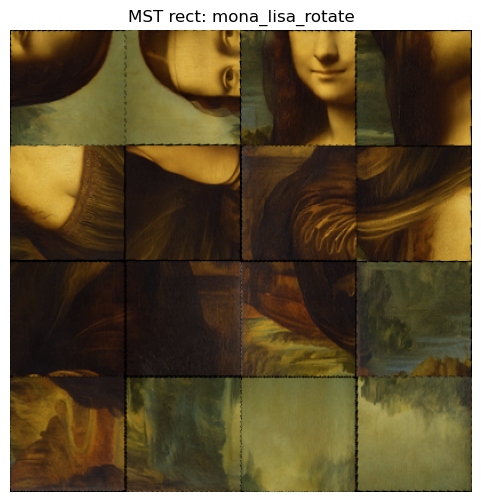

Saved -> ./outputs_mst_rect\mona_lisa_rotate_mst_rect.png


array([[[  0,   0,   0],
        [  4,  12,  16],
        [  9,  30,  42],
        ...,
        [ 11,  32,  41],
        [ 12,  35,  45],
        [  0,   0,   0]],

       [[ 10,  31,  40],
        [ 45, 138, 181],
        [ 30, 107, 149],
        ...,
        [ 49, 145, 187],
        [ 43, 128, 165],
        [  0,   0,   0]],

       [[  1,   4,   6],
        [ 45, 141, 184],
        [ 27, 102, 142],
        ...,
        [ 45, 141, 183],
        [ 40, 126, 165],
        [  0,   0,   0]],

       ...,

       [[ 12,  17,  26],
        [ 40,  56,  82],
        [ 41,  59,  84],
        ...,
        [ 40,  83,  86],
        [ 36,  79,  84],
        [ 17,  38,  41]],

       [[  0,   0,   0],
        [ 40,  52,  71],
        [ 46,  60,  81],
        ...,
        [ 38,  77,  80],
        [ 33,  72,  78],
        [ 13,  29,  32]],

       [[  0,   0,   0],
        [ 20,  25,  33],
        [ 19,  23,  30],
        ...,
        [ 11,  23,  24],
        [ 13,  29,  32],
        [  5,  11,  12]]

In [40]:
solve_puzzle_mst_rectangular("./data/mona_lisa_rotate.rgb")

=== Solving: ./data/more_samples/sample1/sample1_rotate.rgb ===
Reading input...
Segmenting pieces...
Found 20 pieces.
Deskewing pieces (with masks)...
Building rotations + mask-aware signatures...
Done preprocessing (aliasing-safe).
sample1_rotate.rgb: 20 pieces
Border threshold: 315.47736
Using grid 4 x 5 for N=20
Trying 2 seeds for top-left
Best seed: (8, 3) with seam cost: 12087.716186824957


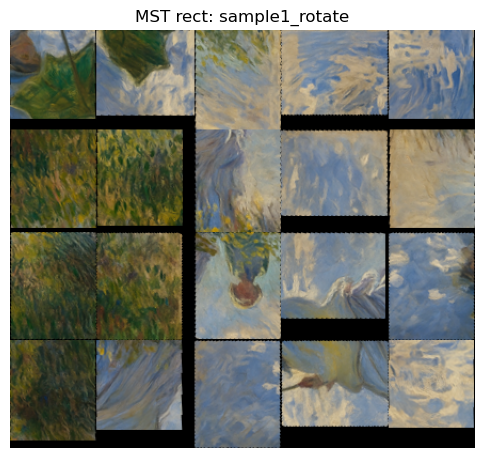

Saved -> ./outputs_mst_rect\sample1_rotate_mst_rect.png


array([[[ 90,  91,  84],
        [101, 101,  95],
        [108, 106,  98],
        ...,
        [135, 155, 165],
        [120, 151, 169],
        [  0,   0,   0]],

       [[118, 117, 109],
        [112, 108, 100],
        [115, 107,  98],
        ...,
        [134, 148, 152],
        [128, 154, 167],
        [  0,   0,   0]],

       [[107,  99,  91],
        [121, 112, 103],
        [125, 113, 103],
        ...,
        [140, 142, 141],
        [133, 150, 159],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [41]:
solve_puzzle_mst_rectangular("./data/more_samples/sample1/sample1_rotate.rgb")

=== Solving: ./data/more_samples/sample2/sample2_rotate.rgb ===
Reading input...
Segmenting pieces...
Found 20 pieces.
Deskewing pieces (with masks)...
Building rotations + mask-aware signatures...
Done preprocessing (aliasing-safe).
sample2_rotate.rgb: 20 pieces
Border threshold: 782.3903
Using grid 4 x 5 for N=20
Trying 80 seeds for top-left
Best seed: (3, 3) with seam cost: 16960.36772857071


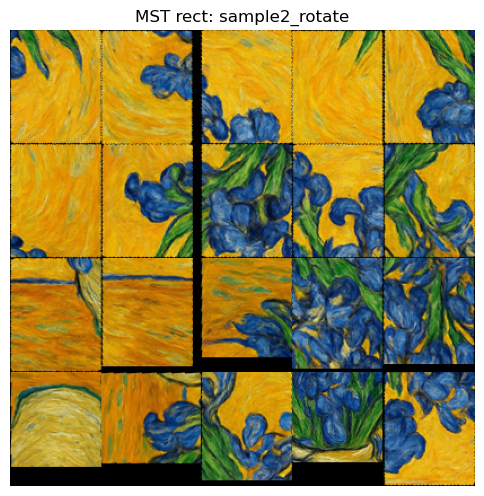

Saved -> ./outputs_mst_rect\sample2_rotate_mst_rect.png


array([[[  0,   0,   0],
        [ 31,  18,   8],
        [134,  76,  31],
        ...,
        [109,  51,   9],
        [ 79,  39,   8],
        [ 42,  22,   5]],

       [[  0,   0,   0],
        [ 91,  53,  22],
        [137,  78,  33],
        ...,
        [103,  45,   6],
        [118,  58,  12],
        [ 93,  46,   8]],

       [[ 18,  10,   3],
        [143,  80,  30],
        [135,  75,  31],
        ...,
        [ 96,  41,   5],
        [112,  54,  12],
        [113,  53,   7]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 38, 177, 227],
        [ 30, 170, 225],
        [  9,  58,  77]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 48, 178, 223],
        [ 20, 120, 158],
        [  2,  10,  14]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 16,  56,  69],
        [  0,   0,   0],
        [  0,   0,   0]]

In [42]:
solve_puzzle_mst_rectangular("./data/more_samples/sample2/sample2_rotate.rgb")

=== Solving: ./data/more_samples/sample3/sample3_rotate.rgb ===
Reading input...
Segmenting pieces...
Found 20 pieces.
Deskewing pieces (with masks)...
Building rotations + mask-aware signatures...
Done preprocessing (aliasing-safe).
sample3_rotate.rgb: 20 pieces
Border threshold: 537.9694
Using grid 4 x 5 for N=20
Trying 80 seeds for top-left
Best seed: (5, 0) with seam cost: 17048.714854005917


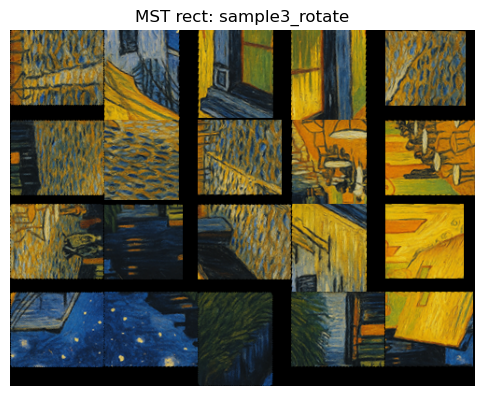

Saved -> ./outputs_mst_rect\sample3_rotate_mst_rect.png


array([[[  2,   4,   7],
        [ 11,  34,  59],
        [ 29,  86, 131],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 23,  51,  75],
        [ 22,  65, 115],
        [ 20,  87, 150],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  8,  19,  32],
        [ 18,  55, 103],
        [ 14,  63, 130],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [43]:
solve_puzzle_mst_rectangular("./data/more_samples/sample3/sample3_rotate.rgb")

cluster the pieces

In [20]:
import numpy as np

path = "./data/more_samples/sample1/sample1_rotate.rgb"

uprights, masks, rotations, rotations_masks, sigs = \
    load_puzzle_pieces_masked(path)

# Collect (height, width) for each upright piece
sizes = [img.shape[:2] for img in uprights]   # (H, W)
print("All piece sizes (H, W):")
for idx, (h, w) in enumerate(sizes):
    print(f"Piece {idx:2d}: {h:4d} x {w:4d}")

# Unique exact sizes
unique_sizes = sorted(set(sizes))
print("\nUnique EXACT sizes:")
for (h, w) in unique_sizes:
    count = sum(1 for s in sizes if s == (h, w))
    print(f"{h:4d} x {w:4d}  -> {count} pieces")


Reading input...
Segmenting pieces...
Found 20 pieces.
Deskewing pieces (with masks)...
Building rotations + mask-aware signatures...
Done preprocessing (aliasing-safe).
All piece sizes (H, W):
Piece  0:   81 x   84
Piece  1:   81 x  101
Piece  2:   81 x   92
Piece  3:   81 x   92
Piece  4:   81 x  101
Piece  5:   81 x  100
Piece  6:   80 x   84
Piece  7:   81 x   94
Piece  8:   81 x   84
Piece  9:   81 x   96
Piece 10:   81 x  101
Piece 11:   81 x   98
Piece 12:   81 x   94
Piece 13:   81 x  101
Piece 14:   81 x  100
Piece 15:   81 x   90
Piece 16:   81 x   92
Piece 17:   81 x  101
Piece 18:   81 x  101
Piece 19:   80 x   82

Unique EXACT sizes:
  80 x   82  -> 1 pieces
  80 x   84  -> 1 pieces
  81 x   84  -> 2 pieces
  81 x   90  -> 1 pieces
  81 x   92  -> 3 pieces
  81 x   94  -> 2 pieces
  81 x   96  -> 1 pieces
  81 x   98  -> 1 pieces
  81 x  100  -> 2 pieces
  81 x  101  -> 6 pieces


In [13]:
tol = 2  # pixels

def cluster_sizes_with_tolerance(sizes, tol=2):
    clusters = []
    for (h, w) in sizes:
        placed = False
        for cl in clusters:
            (rh, rw) = cl["rep"]
            if abs(h - rh) <= tol and abs(w - rw) <= tol:
                cl["items"].append((h, w))
                placed = True
                break
        if not placed:
            clusters.append({"rep": (h, w), "items": [(h, w)]})
    return clusters

clusters = cluster_sizes_with_tolerance(sizes, tol=2)

print(f"\nSize clusters with tolerance ±{tol} px:")
for k, cl in enumerate(clusters):
    rh, rw = cl["rep"]
    print(f"Cluster {k}: around {rh} x {rw}  -> {len(cl['items'])} pieces")



Size clusters with tolerance ±2 px:
Cluster 0: around 81 x 84  -> 4 pieces
Cluster 1: around 81 x 101  -> 8 pieces
Cluster 2: around 81 x 92  -> 6 pieces
Cluster 3: around 81 x 96  -> 2 pieces


In [15]:
path = "./data/starry_night_rotate.rgb"

uprights, masks, rotations, rotations_masks, sigs = \
    load_puzzle_pieces_masked(path)

# Collect (height, width) for each upright piece
sizes = [img.shape[:2] for img in uprights]   # (H, W)
print("All piece sizes (H, W):")
for idx, (h, w) in enumerate(sizes):
    print(f"Piece {idx:2d}: {h:4d} x {w:4d}")

# Unique exact sizes
unique_sizes = sorted(set(sizes))
print("\nUnique EXACT sizes:")
for (h, w) in unique_sizes:
    count = sum(1 for s in sizes if s == (h, w))
    print(f"{h:4d} x {w:4d}  -> {count} pieces")

Reading input...
Segmenting pieces...
Found 16 pieces.
Deskewing pieces (with masks)...
Building rotations + mask-aware signatures...
Done preprocessing (aliasing-safe).
All piece sizes (H, W):
Piece  0:  101 x  101
Piece  1:  101 x  101
Piece  2:  101 x  101
Piece  3:  101 x  101
Piece  4:  101 x  101
Piece  5:  101 x  101
Piece  6:  101 x  101
Piece  7:  101 x  101
Piece  8:  101 x  101
Piece  9:  100 x  101
Piece 10:  101 x  101
Piece 11:  101 x  101
Piece 12:  101 x  101
Piece 13:  101 x  101
Piece 14:  101 x  101
Piece 15:  101 x  101

Unique EXACT sizes:
 100 x  101  -> 1 pieces
 101 x  101  -> 15 pieces


-------------------------- ignore cluster differencr-------------------